# Case study: PCA + Clustering

## Problem Statement

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid.

## Business Goal

Our job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

<a id="1"></a> <br>
## Step 1: Reading and Understanding the Data

In [1]:
# import all libraries and dependencies for dataframe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
sns.set(style='darkgrid')
import matplotlib.ticker as plticker
%matplotlib inline

# import all libraries and dependencies for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# import all libraries and dependencies for clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
# Reading the country file on which analysis needs to be done

df_country = pd.read_csv('Country-data.csv')

df_country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


In [3]:
# Reading the data dictionary file

df_structure = pd.read_csv('../input/pca-kmeans-hierarchical-clustering/data-dictionary.csv')
df_structure.head(10)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services. Given as %age of the Total GDP
3,health,Total health spending as %age of Total GDP
4,imports,Imports of goods and services. Given as %age of the Total GDP
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [4]:
df_country.shape

(167, 10)

In [5]:
df_country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,41.1090,6.8157,46.8902,17144.6886,7.7818,70.5557,2.9480,12964.1557
std,40.3289,27.4120,2.7468,24.2096,19278.0677,10.5707,8.8932,1.5138,18328.7048
min,2.6000,0.1090,1.8100,0.0659,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,23.8000,4.9200,30.2000,3355.0000,1.8100,65.3000,1.7950,1330.0000
50%,19.3000,35.0000,6.3200,43.3000,9960.0000,5.3900,73.1000,2.4100,4660.0000
75%,62.1000,51.3500,8.6000,58.7500,22800.0000,10.7500,76.8000,3.8800,14050.0000
max,208.0000,200.0000,17.9000,174.0000,125000.0000,104.0000,82.8000,7.4900,105000.0000


In [6]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


<a id="2"></a> <br>
## Step 2 : Data Cleansing

We need to do some basic cleansing check in order to feed our model the correct data.

In [7]:
# Calculating the Missing Values % contribution in DF

df_null = df_country.isna().mean()*100
df_null

country      0.0000
child_mort   0.0000
exports      0.0000
health       0.0000
imports      0.0000
income       0.0000
inflation    0.0000
life_expec   0.0000
total_fer    0.0000
gdpp         0.0000
dtype: float64

#### Inference:
- None of the columns have null values hence no imputation or drop required.

In [8]:
# Datatype check for the dataframe

df_country.dtypes

country       object 
child_mort    float64
exports       float64
health        float64
imports       float64
income        int64  
inflation     float64
life_expec    float64
total_fer     float64
gdpp          int64  
dtype: object

#### Inference:
- None of the columns have inconsistent datatype, hence no conversion is required.

In [9]:
# Duplicates check

df_country.loc[df_country.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


In [10]:
# Segregation of Numerical and Categorical Variables/Columns

cat_col = df_country.select_dtypes(include = ['object']).columns
num_col = df_country.select_dtypes(exclude = ['object']).columns

*The dataset seems to be almost clean and hence no such cleansing activities are required.*

<a id="3"></a> <br>
## Step 3 : Data Visualization

(9.5, -0.5)

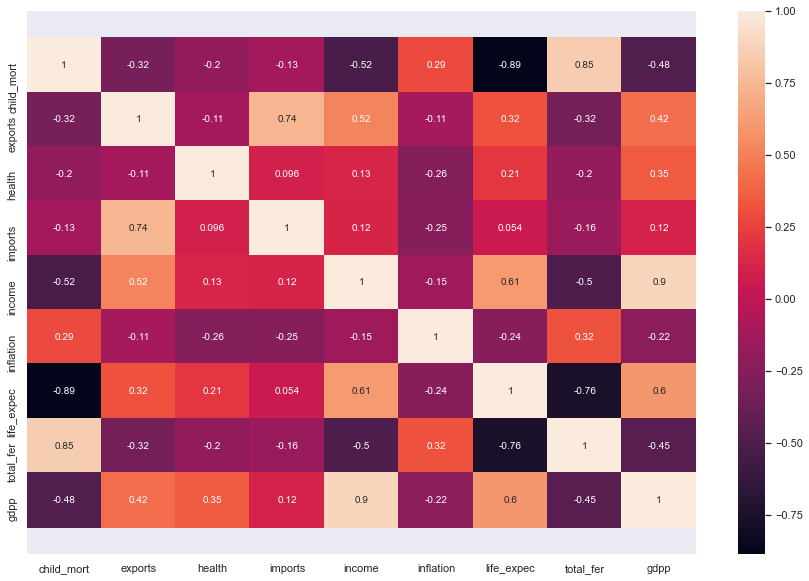

In [11]:
# Heatmap to understand the attributes dependency

plt.figure(figsize = (15,10))        
ax = sns.heatmap(df_country.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Inference:
- `child_mortality` and `life_expentency` are highly correlated with correlation of `-0.89`
- `child_mortality` and `total_fertility` are highly correlated with correlation of `0.85`
- `imports` and `exports` are highly correlated with correlation of `0.74`
- `life_expentency` and `total_fertility` are highly correlated with correlation of `-0.76`

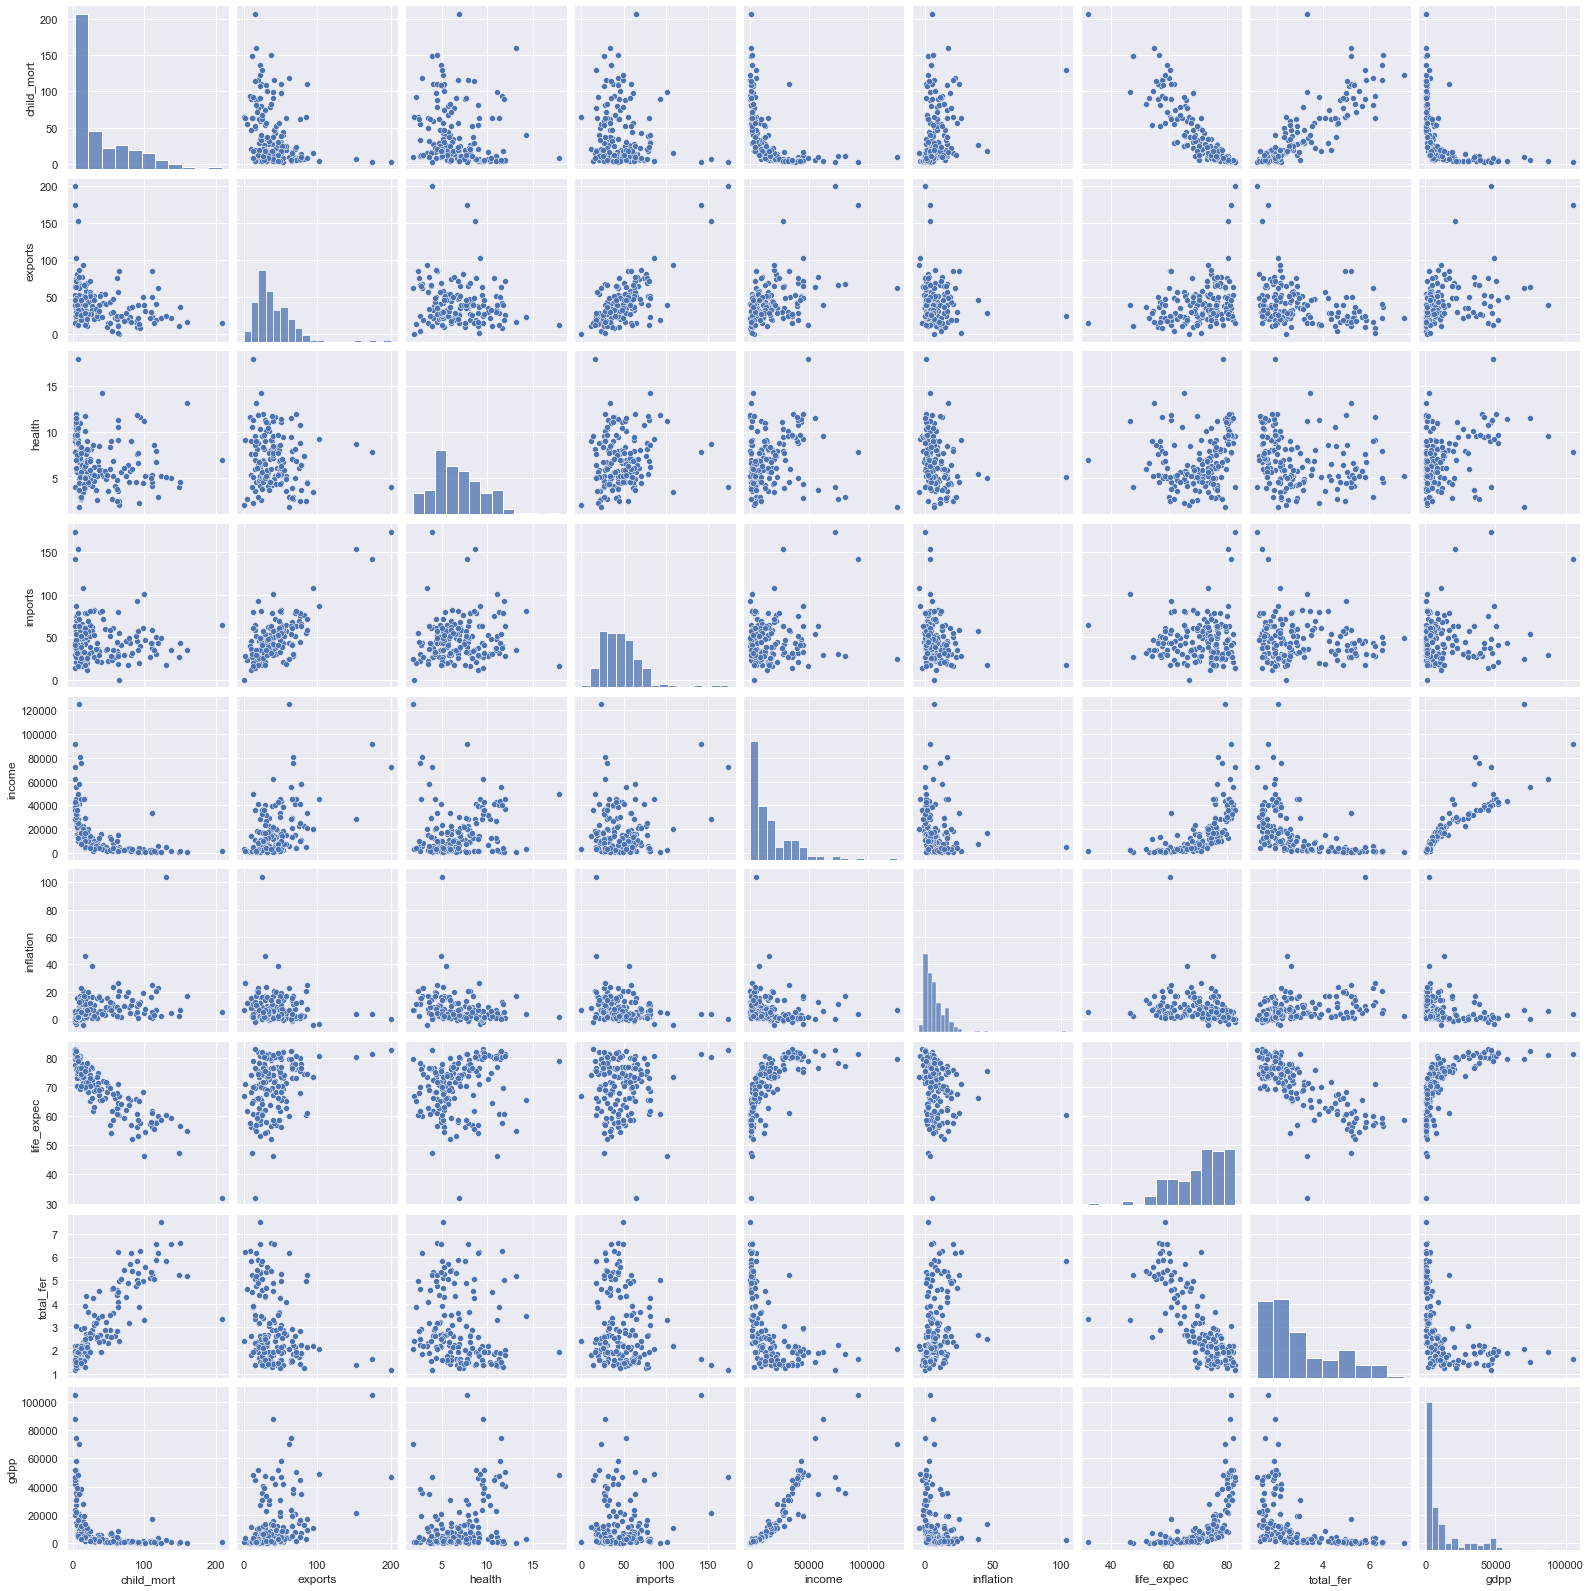

In [12]:
# Pairplot of all numeric columns

sns.pairplot(df_country)

<a id="4"></a> <br>
## Step 4 : Data Preparation

**Derived Metrices**<br>

Deducing imports,exports and health spending from percentage values to actual values of their GDP per capita .Because the percentage values don't give a clear picture of that country. For example Austria and Belarus have almost same exports % but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other.

In [13]:
# Converting exports,imports and health spending percentages to absolute values.

df_country['exports'] = df_country['exports'] * df_country['gdpp']/100
df_country['imports'] = df_country['imports'] * df_country['gdpp']/100
df_country['health'] = df_country['health'] * df_country['gdpp']/100

In [14]:
df_country.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,1145.2000,267.8950,1987.7400,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,1712.6400,185.9820,1400.4400,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,2199.1900,100.6050,1514.3700,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,5551.0000,735.6600,7185.8000,19100,1.4400,76.8000,2.1300,12200


In [15]:
# Dropping Country field as final dataframe will only contain data columns

df_country_drop = df_country.copy()
country = df_country_drop.pop('country')

In [16]:
df_country_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2000,55.3000,41.9174,248.2970,1610,9.4400,56.2000,5.8200,553
1,16.6000,1145.2000,267.8950,1987.7400,9930,4.4900,76.3000,1.6500,4090
2,27.3000,1712.6400,185.9820,1400.4400,12900,16.1000,76.5000,2.8900,4460
3,119.0000,2199.1900,100.6050,1514.3700,5900,22.4000,60.1000,6.1600,3530
4,10.3000,5551.0000,735.6600,7185.8000,19100,1.4400,76.8000,2.1300,12200


#### Rescaling the Features
Most software packages use SVD to compute the principal components and assume that the data is scaled and centred, so it is important to do standardisation/normalisation.
There are two common ways of rescaling:

1. Min-Max scaling<br>
2. Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [17]:
# Standarisation technique for scaling

warnings.filterwarnings("ignore")
scaler = StandardScaler()
df_country_scaled = scaler.fit_transform(df_country_drop)

In [18]:
df_country_scaled

array([[ 1.29153238, -0.4110113 , -0.56503989, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.35019096, -0.43921769, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.31852577, -0.48482608, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541, -0.36146329, -0.53848844, ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.39216643, -0.55059641, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.38395214, -0.54049845, ..., -2.09278484,
         1.6246091 , -0.62954556]])

<a id="5"></a> <br>
## Step 5 : PCA Application

We are doing PCA because we want to remove the redundancies in the data and find the most important directions where the data was aligned. A somewhat similar heuristic is also used by the United Nations to calculate the Human Development Index(HDI) to rank countries on the basis of their development. 

Principal component analysis (PCA) is one of the most commonly used `dimensionality reduction` techniques in the industry. By converting large data sets into smaller ones containing fewer variables, it helps in improving model performance, visualising complex data sets, and in many more areas.

Let's use PCA for dimensionality reduction as from the heatmap it is evident that correlation exists between the attributes.

In [19]:
pca = PCA(svd_solver='randomized', random_state=42)

In [20]:
# Lets apply PCA on the scaled data

pca.fit(df_country_scaled)

PCA(random_state=42, svd_solver='randomized')

In [21]:
# PCA components created 

pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [22]:
# Variance Ratio

pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

Text(0, 0.5, 'Variance Ratio')

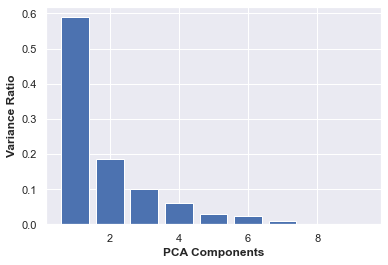

In [23]:
# Variance Ratio bar plot for each PCA components.

ax = plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Components",fontweight = 'bold')
plt.ylabel("Variance Ratio",fontweight = 'bold')

#### Inference:
- With first component variance explained is almost 60%.
- For second component variance explained is almost 20%.

Text(0, 0.5, 'Cumulative Explained Variance')

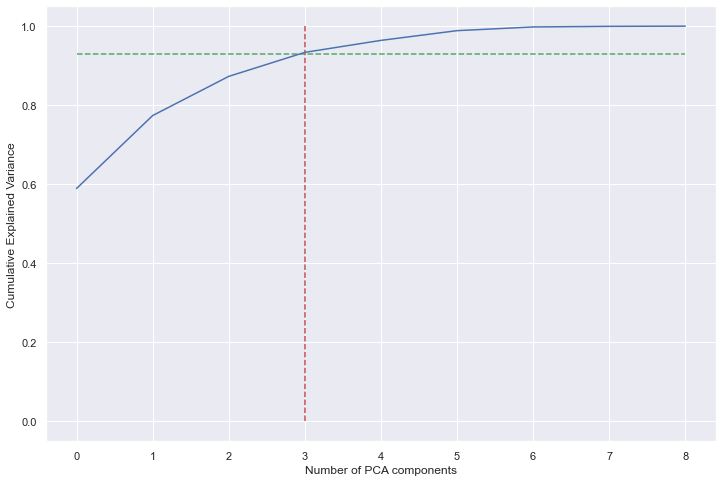

In [24]:
# Scree plot to visualize the Cumulative variance against the Number of components

fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.93, xmax=8, xmin=0, colors="g", linestyles="--")
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')

#### Inference:
It is evident from the above Scree plot that more than 90% variance is explained by the first 3 principal components.
Hence, we will use these components only going forward for Clustering process.

In [25]:
# Checking which attributes are well explained by the pca components

org_col = list(df_country.drop(['country'],axis=1).columns)
attributes_pca = pd.DataFrame({'Attribute':org_col,'PC_1':pca.components_[0],'PC_2':pca.components_[1],'PC_3':pca.components_[2]})

In [26]:
attributes_pca

,Attribute,PC_1,PC_2,PC_3
0,child_mort,-0.3164,0.4763,-0.1500
1,exports,0.3429,0.3973,-0.0306
2,health,0.3585,0.1551,-0.0757
3,imports,0.3449,0.3708,-0.0722
4,income,0.3800,0.1284,0.1458
5,inflation,-0.1431,0.2213,0.9484
6,life_expec,0.3439,-0.3698,0.1968
7,total_fer,-0.3028,0.4597,-0.0778
8,gdpp,0.4000,0.2006,0.0103


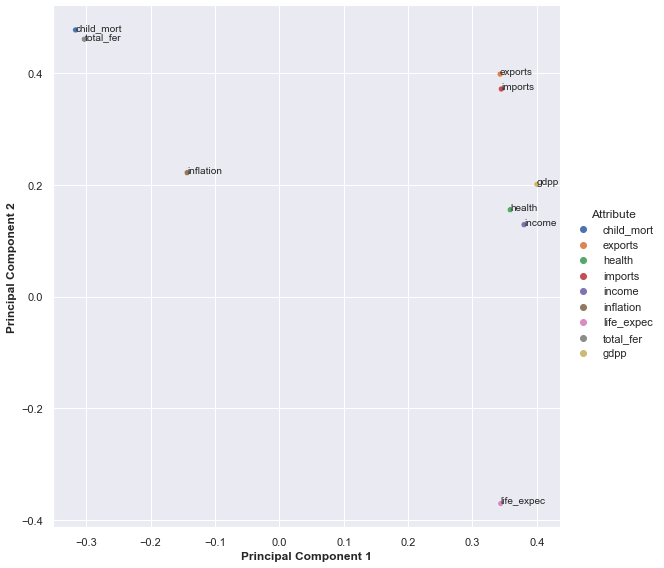

In [27]:
# Plotting the above dataframe for better visualization with PC1 and PC2

sns.pairplot(data=attributes_pca, x_vars=["PC_1"], y_vars=["PC_2"], hue = "Attribute" ,height=8)
plt.xlabel("Principal Component 1",fontweight = 'bold')
plt.ylabel("Principal Component 2",fontweight = 'bold')

for i,txt in enumerate(attributes_pca.Attribute):
    plt.annotate(txt, (attributes_pca.PC_1[i],attributes_pca.PC_2[i]))

#### Inference:
- `life expectency`, `income`, `gdpp` and `health` are very well explained by PC1.
- `imports` and `exports` are well explained by both the components PC1 and PC2.
- `child mortality` and `total fertility` are well explained by PC2.
- `inflation` is neither explained by PC1 nor with PC2

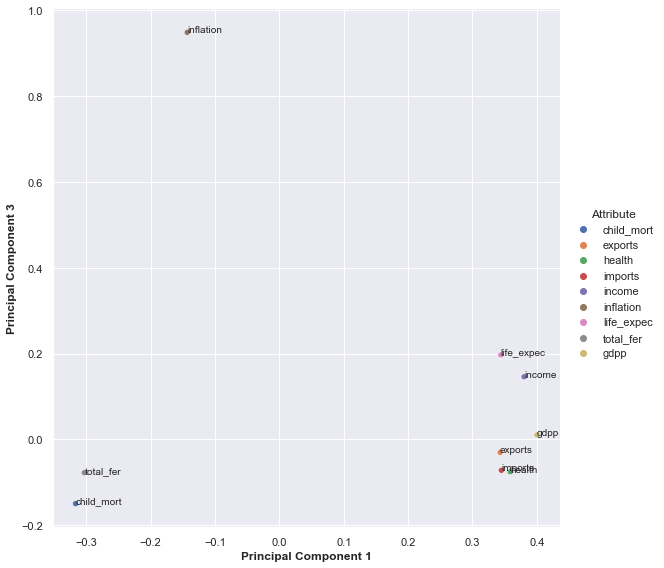

In [28]:
# Plotting the above dataframe with PC1 and PC3 to understand the components which explains inflation.

sns.pairplot(data=attributes_pca, x_vars=["PC_1"], y_vars=["PC_3"], hue = "Attribute" ,height=8)
plt.xlabel("Principal Component 1",fontweight = 'bold')
plt.ylabel("Principal Component 3",fontweight = 'bold')

for i,txt in enumerate(attributes_pca.Attribute):
    plt.annotate(txt, (attributes_pca.PC_1[i],attributes_pca.PC_3[i]))

#### Inference:
- `inflation` is well explained by PC3.

Since 90% variance is explained by 3 principal components, lets build the dataframe using those 3 components only.

In [29]:
# Building the dataframe using Incremental PCA for better efficiency.

inc_pca = IncrementalPCA(n_components=3)

In [30]:
# Fitting the scaled df on incremental pca

df_inc_pca = inc_pca.fit_transform(df_country_scaled)
df_inc_pca

array([[-2.63744157e+00,  1.46903797e+00, -5.41359106e-01],
       [-2.22769569e-02, -1.43189586e+00, -2.07009539e-02],
       [-4.57626261e-01, -6.73300938e-01,  9.61867281e-01],
       [-2.72452030e+00,  2.17458267e+00,  6.06686548e-01],
       [ 6.49848516e-01, -1.02437392e+00, -2.50102847e-01],
       [ 3.71968554e-02, -6.80889086e-01,  1.46696276e+00],
       [-3.32691520e-01, -1.27451685e+00,  1.76636110e-01],
       [ 3.18036154e+00, -2.50784878e-01, -1.16877257e-01],
       [ 3.81568156e+00,  2.56083499e-01, -2.70495294e-01],
       [-4.67515152e-01, -4.93492360e-01,  6.03288028e-01],
       [ 1.49875246e+00, -4.28907400e-01, -5.50237572e-01],
       [ 1.47097104e+00, -3.26795693e-01,  4.28411771e-01],
       [-1.01419903e+00, -7.11807758e-01, -1.16988551e-01],
       [ 8.45238116e-01, -1.00860625e+00, -4.17261615e-01],
       [-1.34473920e-02, -9.82186148e-01,  8.80913018e-01],
       [ 3.96087770e+00,  8.38740841e-01, -2.94077196e-01],
       [-4.02707071e-01, -9.21816189e-01

In [31]:
# Creating new dataframe with Principal components

df_pca = pd.DataFrame(df_inc_pca, columns=["PC_1", "PC_2","PC_3"])
df_pca_final = pd.concat([country, df_pca], axis=1)
df_pca_final.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.6374,1.4690,-0.5414
1,Albania,-0.0223,-1.4319,-0.0207
2,Algeria,-0.4576,-0.6733,0.9619
3,Angola,-2.7245,2.1746,0.6067
4,Antigua and Barbuda,0.6498,-1.0244,-0.2501


(3.5, -0.5)

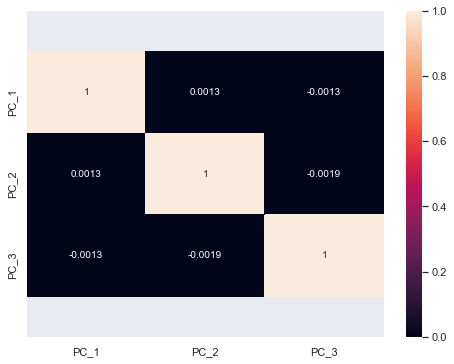

In [32]:
# Plotting Heatmap to check is there still dependency in the dataset.

plt.figure(figsize = (8,6))        
ax = sns.heatmap(df_pca_final.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Inference:
As we can see from above heatmap that the correlation among the attributes is almost `0`, we can proceed with this dataframe.

<AxesSubplot:xlabel='PC_3', ylabel='PC_2'>

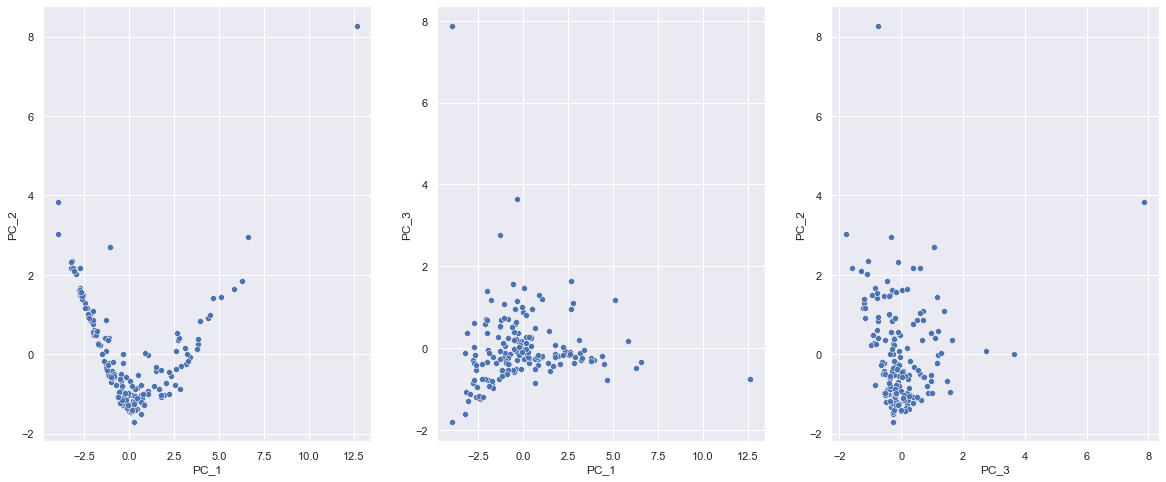

In [33]:
# Scatter Plot to visualize the spread of data across PCA components

plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
sns.scatterplot(data=df_pca_final, x='PC_1', y='PC_2')
plt.subplot(1,3,2)
sns.scatterplot(data=df_pca_final, x='PC_1', y='PC_3')
plt.subplot(1,3,3)
sns.scatterplot(data=df_pca_final, x='PC_3', y='PC_2')

#### Outlier Analysis and Treatment

There are 2 types of outliers and we will treat outliers as it can skew our dataset¶
- Statistical
- Domain specific

Text(0.5, 0, 'PC Components')

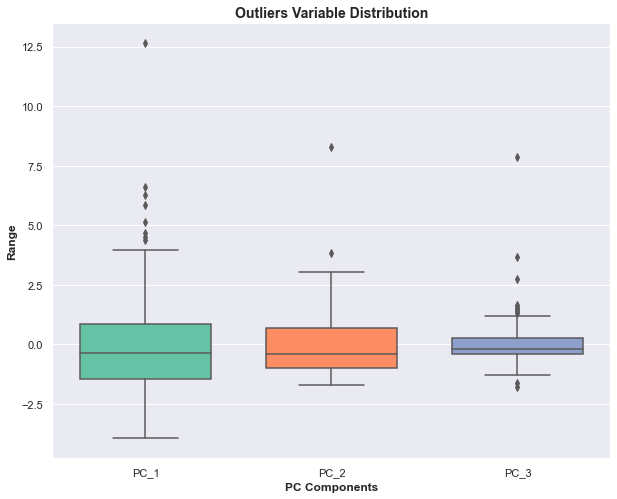

In [34]:
# Outlier Analysis 

outliers = ['PC_1','PC_2','PC_3']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_pca_final[outliers], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("PC Components", fontweight = 'bold')

In [35]:
# Statstical Outlier treatment for PC_1

Q1 = df_pca_final.PC_1.quantile(0.05)
Q3 = df_pca_final.PC_1.quantile(0.95)
IQR = Q3 - Q1
df_pca_final = df_pca_final[(df_pca_final.PC_1 >= Q1) & (df_pca_final.PC_1 <= Q3)]

# Statstical Outlier treatment for PC_2

Q1 = df_pca_final.PC_2.quantile(0.05)
Q3 = df_pca_final.PC_2.quantile(0.95)
IQR = Q3 - Q1
df_pca_final = df_pca_final[(df_pca_final.PC_2 >= Q1) & (df_pca_final.PC_2 <= Q3)]

# Statstical Outlier treatment for PC_3

Q1 = df_pca_final.PC_3.quantile(0.05)
Q3 = df_pca_final.PC_3.quantile(0.95)
IQR = Q3 - Q1
df_pca_final = df_pca_final[(df_pca_final.PC_3 >= Q1) & (df_pca_final.PC_3 <= Q3)]

Text(0.5, 0, 'PC Components')

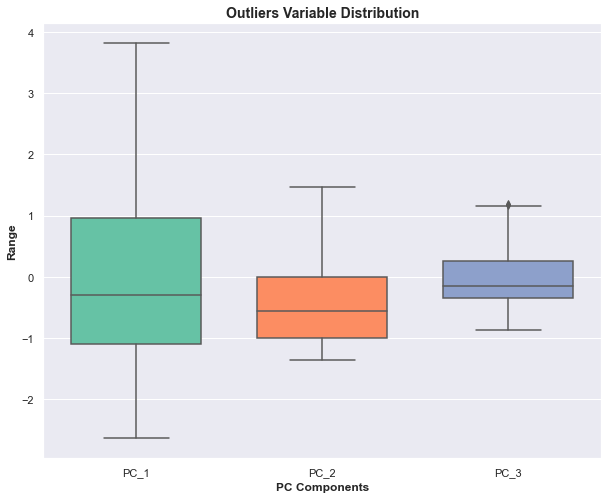

In [36]:
# Plot after Outlier removal 

outliers = ['PC_1','PC_2','PC_3']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_pca_final[outliers], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("PC Components", fontweight = 'bold')

In [37]:
# Reindexing the df after outlier removal

df_pca_final = df_pca_final.reset_index(drop=True)
df_pca_final_data = df_pca_final.drop(['country'],axis=1)
df_pca_final.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.6374,1.4690,-0.5414
1,Algeria,-0.4576,-0.6733,0.9619
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501
3,Armenia,-0.3327,-1.2745,0.1766
4,Australia,3.1804,-0.2508,-0.1169


<a id="7"></a> <br>
## Step 7 : Model Building

### K- means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

First we initialize k points, called means, randomly.
We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
We repeat the process for a given number of iterations and at the end, we have our clusters.

**Finding the Optimal Number of Clusters**

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

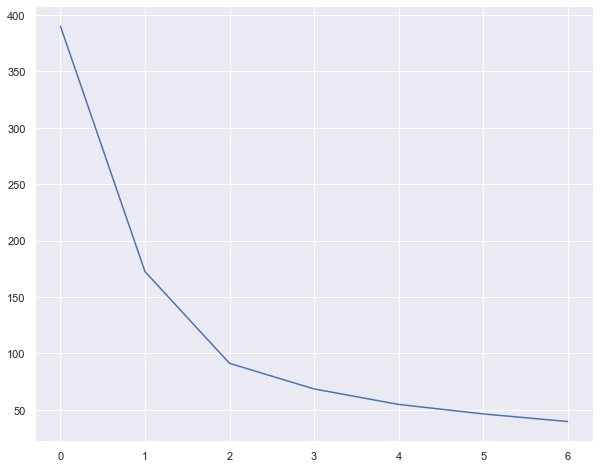

In [38]:
# Elbow curve method to find the ideal number of clusters.
ssd = []
for num_clusters in list(range(1,8)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50,random_state= 100)
    model_clus.fit(df_pca_final_data)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

#### Inference:

Looking at the above elbow curve it looks good to proceed with either 4 or 5 clusters.

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [39]:
# Silhouette score analysis to find the ideal number of clusters for K-means clustering

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state= 100)
    kmeans.fit(df_pca_final_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_pca_final_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.4873400103541441
For n_clusters=3, the silhouette score is 0.4639771456218248
For n_clusters=4, the silhouette score is 0.39873565683671486
For n_clusters=5, the silhouette score is 0.3617098033392007
For n_clusters=6, the silhouette score is 0.36603716544306125
For n_clusters=7, the silhouette score is 0.3703642483431638
For n_clusters=8, the silhouette score is 0.37523701546018884


In [40]:
#K-means with k=4 clusters

cluster4 = KMeans(n_clusters=4, max_iter=50, random_state= 100)
cluster4.fit(df_pca_final_data)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [41]:
# Cluster labels

cluster4.labels_

array([3, 0, 2, 0, 1, 1, 0, 2, 2, 0, 2, 0, 0, 0, 0, 3, 2, 2, 0, 1, 0, 2,
       0, 0, 3, 3, 2, 1, 2, 0, 0, 0, 0, 3, 2, 0, 1, 1, 3, 3, 0, 1, 3, 2,
       0, 0, 0, 2, 1, 0, 0, 0, 3, 2, 1, 0, 1, 0, 0, 3, 1, 0, 3, 2, 3, 2,
       2, 3, 2, 2, 1, 3, 2, 0, 0, 0, 0, 3, 0, 1, 2, 3, 2, 0, 0, 0, 2, 2,
       2, 0, 3, 0, 2, 2, 1, 3, 3, 2, 1, 0, 3, 0, 1, 0, 3, 0, 0, 2, 0, 3,
       0, 1, 1, 1, 2, 0, 0, 0, 3])

In [42]:
# Assign the label

df_pca_final['Cluster_Id4'] = cluster4.labels_
df_pca_final.head()

,country,PC_1,PC_2,PC_3,Cluster_Id4
0,Afghanistan,-2.6374,1.4690,-0.5414,3
1,Algeria,-0.4576,-0.6733,0.9619,0
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501,2
3,Armenia,-0.3327,-1.2745,0.1766,0
4,Australia,3.1804,-0.2508,-0.1169,1


In [43]:
# Number of countries in each cluster

df_pca_final['Cluster_Id4'].value_counts()

0    48
2    29
3    23
1    19
Name: Cluster_Id4, dtype: int64

#### Inference:
It seems there are good number of countries in each clusters.

<AxesSubplot:xlabel='PC_1', ylabel='PC_3'>

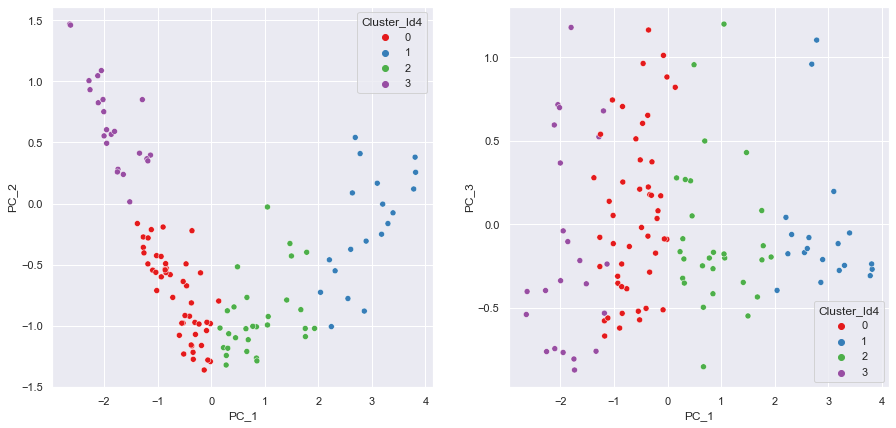

In [44]:
# Scatter plot on Principal components to visualize the spread of the data

fig, axes = plt.subplots(1,2, figsize=(15,7))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id4',legend='full',palette="Set1",data=df_pca_final,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id4',legend='full',palette="Set1",data=df_pca_final,ax=axes[1])

#### Inference:
- In plot 1, it seems lot of intra-distance between the cluster elements, which is not a good sign.

In [45]:
# Lets drop the Cluster Id created with 4 clusters and proceed with 5 clusters.

df_pca_final = df_pca_final.drop('Cluster_Id4',axis=1)

In [46]:
#K-means with k=5 clusters

cluster5 = KMeans(n_clusters=5, max_iter=50,random_state=100)
cluster5.fit(df_pca_final_data)

KMeans(max_iter=50, n_clusters=5, random_state=100)

In [47]:
# Cluster labels

cluster5.labels_

array([0, 4, 1, 4, 2, 2, 4, 1, 1, 3, 1, 4, 3, 3, 3, 0, 4, 4, 3, 2, 3, 4,
       4, 4, 0, 0, 1, 2, 1, 4, 4, 3, 4, 0, 1, 3, 2, 2, 0, 0, 4, 2, 0, 1,
       4, 3, 3, 1, 2, 3, 3, 4, 0, 1, 2, 4, 2, 4, 4, 0, 2, 3, 0, 1, 0, 4,
       1, 0, 4, 4, 2, 0, 4, 3, 4, 3, 3, 0, 3, 2, 1, 0, 4, 4, 4, 3, 1, 1,
       4, 4, 0, 3, 1, 1, 1, 0, 0, 1, 1, 4, 0, 4, 2, 3, 0, 3, 4, 4, 3, 0,
       4, 2, 2, 2, 4, 3, 3, 4, 0])

In [48]:
# assign the label

df_pca_final['Cluster_Id'] = cluster5.labels_
df_pca_final.head()

,country,PC_1,PC_2,PC_3,Cluster_Id
0,Afghanistan,-2.6374,1.4690,-0.5414,0
1,Algeria,-0.4576,-0.6733,0.9619,4
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501,1
3,Armenia,-0.3327,-1.2745,0.1766,4
4,Australia,3.1804,-0.2508,-0.1169,2


In [49]:
# Number of countries in each cluster

df_pca_final['Cluster_Id'].value_counts()

4    35
3    24
0    23
1    20
2    17
Name: Cluster_Id, dtype: int64

#### Inference:
It seems there are good number of countries in each clusters.

<AxesSubplot:xlabel='PC_1', ylabel='PC_3'>

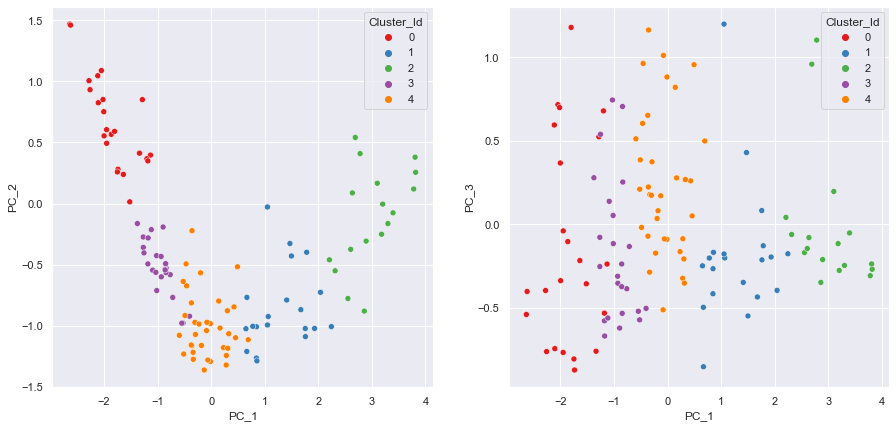

In [50]:
# Scatter plot on Principal components to visualize the spread of the data
fig, axes = plt.subplots(1,2, figsize=(15,7))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id',legend='full',palette="Set1",data=df_pca_final,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id',legend='full',palette="Set1",data=df_pca_final,ax=axes[1])

#### Inference:
- Here also we got the same issue as with 4 clusters but we got a new segment, so lets proceed with K means using 5 clusters.

We have visualized the data on the principal components and saw some good clusters were formed but some were not so good hence let's now visualize the data on the original attributes.

In [51]:
# Merging the df with PCA with original df

df_merge = pd.merge(df_country,df_pca_final,on='country')
df_merge_col = df_merge[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','Cluster_Id']]

# Creating df with mean values
cluster_child = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).child_mort.mean())
cluster_export = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).exports.mean())
cluster_import = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).imports.mean())
cluster_health = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).health.mean())
cluster_income = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).income.mean())
cluster_inflation = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).inflation.mean())         
cluster_lifeexpec = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).life_expec.mean())
cluster_totalfer = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).total_fer.mean())
cluster_gdpp = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).gdpp.mean())

df_concat = pd.concat([pd.Series([0,1,2,3,4]),cluster_child,cluster_export,cluster_import,cluster_health,cluster_income
                       ,cluster_inflation,cluster_lifeexpec,cluster_totalfer,cluster_gdpp], axis=1)
df_concat.columns = ["Cluster_Id", "Child_Mortality", "Exports", "Imports","Health_Spending","Income","Inflation","Life_Expectancy","Total_Fertility","GDPpcapita"]
df_concat.head()

,Cluster_Id,Child_Mortality,Exports,Imports,Health_Spending,Income,Inflation,Life_Expectancy,Total_Fertility,GDPpcapita
0,0,68.4783,884.7745,838.6342,135.8739,4650.8696,10.7113,62.1696,4.5074,2152.7391
1,1,7.1400,9374.4700,9371.0950,1442.0290,26050.0000,1.6395,76.9150,1.7400,18835.0000
2,2,5.1412,16736.1118,15324.9353,3954.5006,41705.8824,2.8236,80.4765,1.7765,40911.7647
3,3,37.8875,896.5533,1187.5125,123.4549,5275.0000,6.5259,68.9583,2.9537,2364.2500
4,4,18.1686,2622.8243,2635.5677,411.1251,13102.0000,8.0534,74.0457,2.1071,6497.1429


In [52]:
df_merge_col.head(5)

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,0
1,Algeria,27.3000,1712.6400,1400.4400,185.9820,12900,16.1000,76.5000,2.8900,4460,4
2,Antigua and Barbuda,10.3000,5551.0000,7185.8000,735.6600,19100,1.4400,76.8000,2.1300,12200,1
3,Armenia,18.1000,669.7600,1458.6600,141.6800,6700,7.7700,73.3000,1.6900,3220,4
4,Australia,4.8000,10276.2000,10847.1000,4530.8700,41400,1.1600,82.0000,1.9300,51900,2


From the business understanding we have learnt that `Child_Mortality`, `Income`, `Gdpp` are some important factors which decides the development of any country.
We have also cross checked with Principal components and found that these variables have good score in PCA.
Hence, we will proceed with analyzing these 3 components to build some meaningful clusters.

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

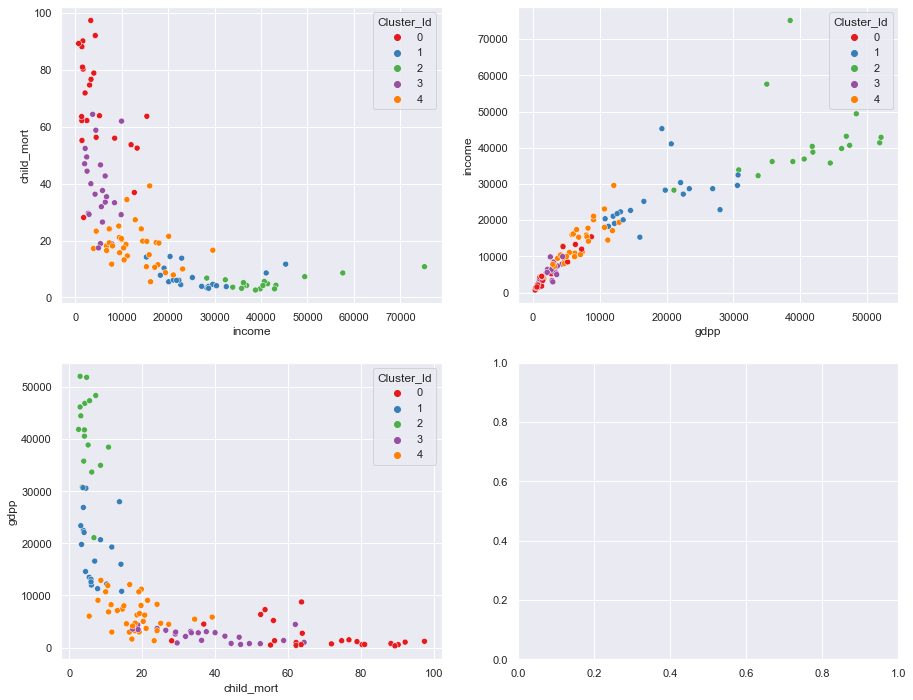

In [53]:
# Scatter plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.scatterplot(x = 'income', y = 'child_mort',hue='Cluster_Id',data = df_merge_col,legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'gdpp', y = 'income',hue='Cluster_Id', data = df_merge_col,legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue='Cluster_Id', data=df_merge_col,legend='full',palette="Set1",ax=axes[1][0])

<AxesSubplot:xlabel='Cluster_Id', ylabel='gdpp'>

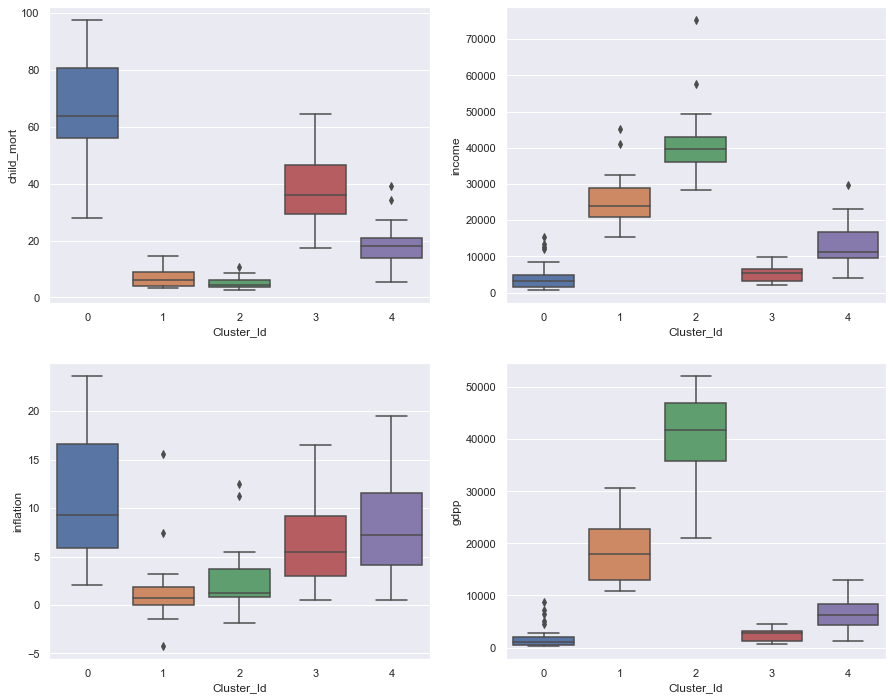

In [54]:
# Box plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'Cluster_Id', y = 'child_mort', data = df_merge_col,ax=axes[0][0])
sns.boxplot(x = 'Cluster_Id', y = 'income', data = df_merge_col,ax=axes[0][1])
sns.boxplot(x = 'Cluster_Id', y = 'inflation', data=df_merge_col,ax=axes[1][0])
sns.boxplot(x = 'Cluster_Id', y = 'gdpp', data=df_merge_col,ax=axes[1][1])

#### Inference:
- Child Mortality is highest for Cluster `0`  and Cluster `3`.These clusters need some aid.
- Income and Gdpp are measures of development. Higher the per capita income and gdpp better is the country's development.
  Income per capita and gdpp seems lowest for countries in clusters `0` and `3`. Hence, these countries need some help.

In [55]:
# List of countries in Cluster 0

df_merge_col[df_merge_col['Cluster_Id']==0]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,0
15,Botswana,52.5000,2768.6000,3257.5500,527.0500,13300,8.9200,57.1000,2.8800,6350,0
24,Comoros,88.2000,126.8850,397.5730,34.6819,1410,3.8700,65.9000,4.7500,769,0
25,"Congo, Rep.",63.9000,2331.7400,1498.7800,67.4040,5190,20.7000,60.4000,4.9500,2740,0
33,Eritrea,55.2000,23.0878,112.3060,12.8212,1420,11.6000,61.7000,4.6100,482,0
38,Gabon,63.7000,5048.7500,1653.7500,306.2500,15400,16.6000,62.9000,4.0800,8750,0
39,Gambia,80.3000,133.7560,239.9740,31.9778,1660,4.3000,65.5000,5.7100,562,0
42,Ghana,74.7000,386.4500,601.2900,68.3820,3060,16.6000,62.2000,4.2700,1310,0
52,Iraq,36.9000,1773.0000,1534.5000,378.4500,12700,16.6000,67.2000,4.5600,4500,0
59,Kenya,62.2000,200.1690,324.9120,45.9325,2480,2.0900,62.8000,4.3700,967,0


In [56]:
# List of countries in Cluster 3

df_merge_col[df_merge_col['Cluster_Id']==3]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
9,Bangladesh,49.4000,121.2800,165.2440,26.6816,2440,7.1400,70.4000,2.3300,758,3
12,Belize,18.8000,2525.8800,2495.5000,225.6800,7880,1.1400,71.4000,2.7100,4340,3
13,Bhutan,42.7000,926.5000,1541.2600,113.3600,6420,5.9900,72.1000,2.3800,2180,3
14,Bolivia,46.6000,815.7600,679.1400,95.8320,5410,8.7800,71.6000,3.2000,1980,3
18,Cambodia,44.4000,425.2260,467.6700,44.6448,2520,3.1200,66.1000,2.8800,786,3
20,Cape Verde,26.5000,1082.3700,2045.5800,135.3790,5830,0.5050,72.5000,2.6700,3310,3
31,Egypt,29.1000,553.8000,691.6000,121.1600,9860,10.1000,70.5000,3.1900,2600,3
35,Fiji,24.1000,2109.7000,2332.3500,177.3900,7350,4.2300,65.3000,2.6700,3650,3
45,Guatemala,35.4000,730.1400,1027.2900,193.8550,6710,5.1400,71.3000,3.3800,2830,3
46,Guyana,37.6000,1562.5600,2404.6400,163.5520,5840,5.7300,65.5000,2.6500,3040,3


Now lets apply Hierarchial Clustering to see if we get any better clusters or not.

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

- Divisive
- Agglomerative.

In [57]:
df_pca_final_data.head()

,PC_1,PC_2,PC_3
0,-2.6374,1.4690,-0.5414
1,-0.4576,-0.6733,0.9619
2,0.6498,-1.0244,-0.2501
3,-0.3327,-1.2745,0.1766
4,3.1804,-0.2508,-0.1169


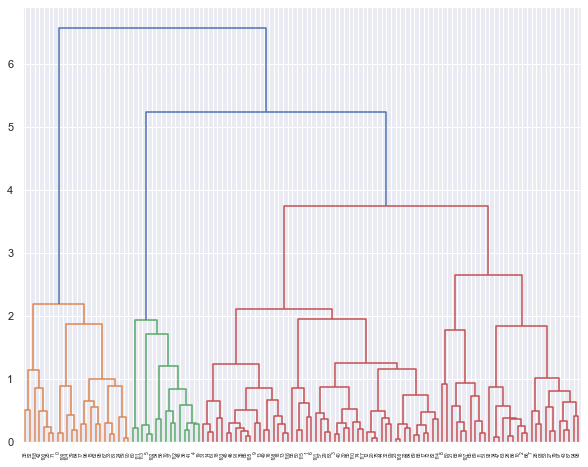

In [58]:
# Complete Linkage

mergings = linkage(df_pca_final_data, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [59]:
df_pca_hc = df_pca_final.copy()
df_pca_hc = df_pca_hc.drop('Cluster_Id',axis=1)
df_pca_hc.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.6374,1.4690,-0.5414
1,Algeria,-0.4576,-0.6733,0.9619
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501
3,Armenia,-0.3327,-1.2745,0.1766
4,Australia,3.1804,-0.2508,-0.1169


In [60]:
# Let cut the tree at height of approx 3 to get 4 clusters and see if it get any better cluster formation.

clusterCut = pd.Series(cut_tree(mergings, n_clusters = 4).reshape(-1,))
df_hc = pd.concat([df_pca_hc, clusterCut], axis=1)
df_hc.columns = ['country', 'PC_1', 'PC_2','PC_3','Cluster_Id']

In [61]:
df_hc.head()

,country,PC_1,PC_2,PC_3,Cluster_Id
0,Afghanistan,-2.6374,1.4690,-0.5414,0
1,Algeria,-0.4576,-0.6733,0.9619,1
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501,2
3,Armenia,-0.3327,-1.2745,0.1766,1
4,Australia,3.1804,-0.2508,-0.1169,3


<AxesSubplot:xlabel='PC_1', ylabel='PC_3'>

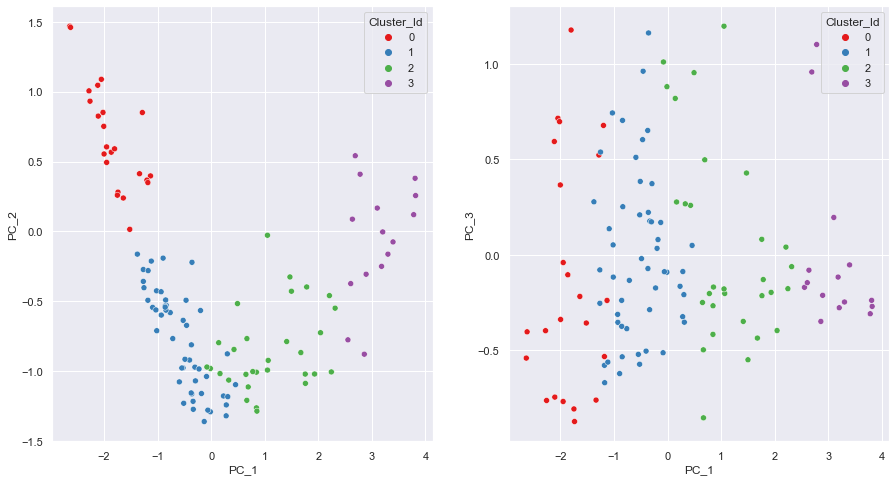

In [62]:
# Scatter plot on Principal components to visualize the spread of the data

fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id',legend='full',palette="Set1",data=df_hc,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id',legend='full',palette="Set1",data=df_hc,ax=axes[1])

#### Inference:
Cluster `4` seems to be not properly formed in Plot 1.

In [63]:
# Merging the df with PCA with original df

df_merge_hc = pd.merge(df_country,df_hc,on='country')
df_merge_col_hc = df_merge[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','Cluster_Id']]

In [64]:
df_merge_col_hc.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,0
1,Algeria,27.3000,1712.6400,1400.4400,185.9820,12900,16.1000,76.5000,2.8900,4460,4
2,Antigua and Barbuda,10.3000,5551.0000,7185.8000,735.6600,19100,1.4400,76.8000,2.1300,12200,1
3,Armenia,18.1000,669.7600,1458.6600,141.6800,6700,7.7700,73.3000,1.6900,3220,4
4,Australia,4.8000,10276.2000,10847.1000,4530.8700,41400,1.1600,82.0000,1.9300,51900,2


<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

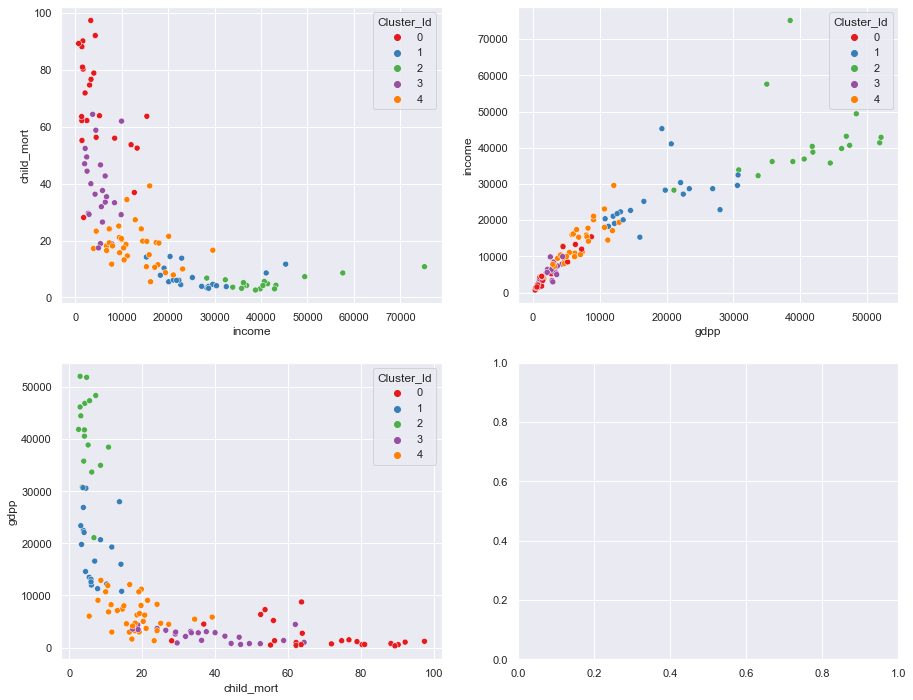

In [65]:
# Scatter plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.scatterplot(x = 'income', y = 'child_mort',hue='Cluster_Id',data = df_merge_col_hc,legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'gdpp', y = 'income',hue='Cluster_Id', data = df_merge_col_hc,legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue='Cluster_Id', data=df_merge_col_hc,legend='full',palette="Set1",ax=axes[1][0])

**We have analyzed both K-means and Hierarchial clustering and found clusters formed are not identical.
The clusters formed in both the cases are not that great but its better in K-means as compared to Hierarchial.
So, we will proceed with the clusters formed by K-means and based on the information provided by the final clusters we will deduce the final list of countries which are in need of aid.**

<a id="8"></a> <br>
## Step 8 : Final Analysis

We got Cluster `0` and Cluster `3` which are in need of aid.

In [66]:
df_clus0 = df_merge_col[df_merge_col['Cluster_Id'] ==0]

In [67]:
df_clus3 = df_merge_col[df_merge_col['Cluster_Id'] ==3]

In [68]:
# List of countries which need help

df_append= df_clus0.append(df_clus3)

In [69]:
df_append.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,0
15,Botswana,52.5000,2768.6000,3257.5500,527.0500,13300,8.9200,57.1000,2.8800,6350,0
24,Comoros,88.2000,126.8850,397.5730,34.6819,1410,3.8700,65.9000,4.7500,769,0
25,"Congo, Rep.",63.9000,2331.7400,1498.7800,67.4040,5190,20.7000,60.4000,4.9500,2740,0
33,Eritrea,55.2000,23.0878,112.3060,12.8212,1420,11.6000,61.7000,4.6100,482,0


In [70]:
df_append.describe()

,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000
mean,52.8574,890.7892,1016.7848,129.5322,4969.5745,8.5741,65.6362,3.7140,2260.7447,1.5319
std,21.8667,1052.0509,884.9270,137.4050,3507.6196,5.8815,4.7627,1.0647,1900.1757,1.5159
min,17.4000,1.0769,0.6511,12.8212,700.0000,0.5050,54.3000,2.3300,327.0000,0.0000
25%,34.4500,132.5150,278.6810,44.3886,2275.0000,3.8350,62.5000,2.6900,777.5000,0.0000
50%,52.5000,454.0800,691.6000,76.8930,4240.0000,7.1400,66.1000,3.5000,1380.0000,3.0000
75%,64.1500,1044.8850,1609.4700,159.7385,6430.0000,11.2500,69.3000,4.5800,3075.0000,3.0000
max,97.4000,5048.7500,3257.5500,650.8320,15400.0000,23.6000,73.5000,6.1500,8750.0000,3.0000


We have removed few countries during outlier treatment but we might have dropped some countries which might be in need of help.
Let's iterate our final list based on the information from the clusters which were in need of aid.ie, `Cluster 3` and `Cluster 4`

In [71]:
# Based on final clusters information we are going to deduce the final list.
# We observed that mean child mortality is 53 for the selected clusters and hence 
# let's take all the countries with more than this child mortality .

df_final_list = df_country[df_country['child_mort']>53]
df_final_list.shape

(48, 10)

In [72]:
# Let's check the demographic of the resultant data again

df_final_list.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000
mean,93.0208,848.1537,97.5164,754.1698,3695.0625,11.6195,59.5500,4.9121,1797.5000
std,32.4204,2266.2194,149.2196,1509.6237,5325.9968,15.4064,6.5526,1.1486,2852.8295
min,53.7000,1.0769,12.8212,0.6511,609.0000,0.8850,32.1000,2.4100,231.0000
25%,63.8500,101.6303,31.9700,188.8055,1390.0000,3.7925,56.7250,4.3450,551.5000
50%,89.7500,188.2900,48.7265,313.8570,1900.0000,8.2150,60.2500,5.0550,932.0000
75%,111.0000,417.9150,72.7850,571.8375,3785.0000,16.2250,63.8500,5.5975,1377.5000
max,208.0000,14671.8000,766.0800,10071.9000,33700.0000,104.0000,71.1000,7.4900,17100.0000


In [73]:
# We observed that mean income is 3695 for the selected clusters and hence 
# let's take all the countries with less than this income .

df_final_list1 = df_final_list[df_final_list['income']<=3695]
df_final_list1.shape

(35, 10)

In [74]:
# Let's check the demographic of the resultant data again

df_final_list1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000
mean,98.7200,190.7614,56.9363,352.9760,1735.8000,8.4913,58.3771,5.2526,831.2000
std,32.8870,159.7151,56.7278,280.1672,769.1895,6.6906,6.9571,0.8977,606.5572
min,55.2000,20.6052,12.8212,90.5520,609.0000,0.8850,32.1000,3.3000,231.0000
25%,75.7000,80.3515,31.5122,170.5340,1215.0000,2.7900,56.2500,4.8100,470.5000
50%,90.5000,131.9850,41.9174,254.5600,1540.0000,6.3900,58.7000,5.2100,648.0000
75%,112.5000,224.5845,57.8575,400.2865,2135.0000,12.2000,62.0000,5.7650,1085.0000
max,208.0000,617.3200,328.3200,1190.5100,3370.0000,26.5000,71.1000,7.4900,3600.0000


In [75]:
# We observed that mean gdpp is 831 for the selected clusters and hence 
# let's take all the countries with less than this gdpp .

df_final_list2 = df_final_list1[df_final_list1['gdpp']<=831]
df_final_list2.shape

(23, 10)

#### Final List of countries which are in need of the aid based on socio-economic factors.

In [76]:
df_final_list2['country']

0      Afghanistan             
17     Benin                   
25     Burkina Faso            
26     Burundi                 
31     Central African Republic
36     Comoros                 
37     Congo, Dem. Rep.        
50     Eritrea                 
56     Gambia                  
63     Guinea                  
64     Guinea-Bissau           
66     Haiti                   
88     Liberia                 
93     Madagascar              
94     Malawi                  
97     Mali                    
106    Mozambique              
112    Niger                   
126    Rwanda                  
132    Sierra Leone            
147    Tanzania                
150    Togo                    
155    Uganda                  
Name: country, dtype: object

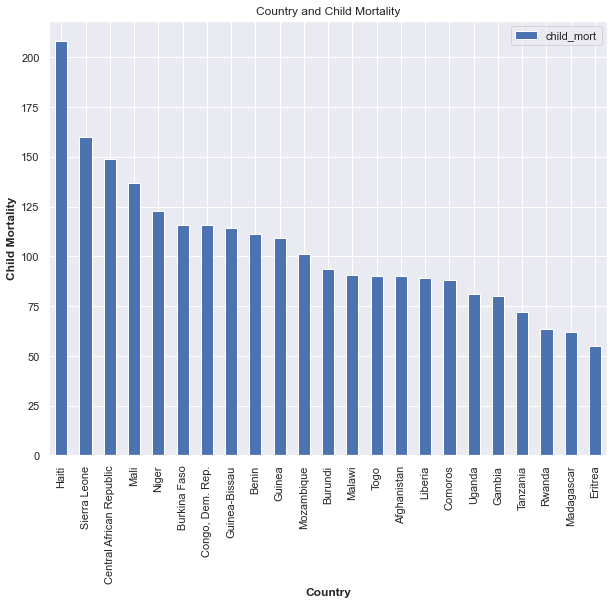

In [77]:
# BarPlot for Child Mortality of countries which are in need of aid

df_list_cm = pd.DataFrame(df_final_list2.groupby(['country'])['child_mort'].mean().sort_values(ascending = False))
df_list_cm.plot.bar()
plt.title('Country and Child Mortality')
plt.xlabel("Country",fontweight = 'bold')
plt.ylabel("Child Mortality", fontsize = 12, fontweight = 'bold')
plt.show()

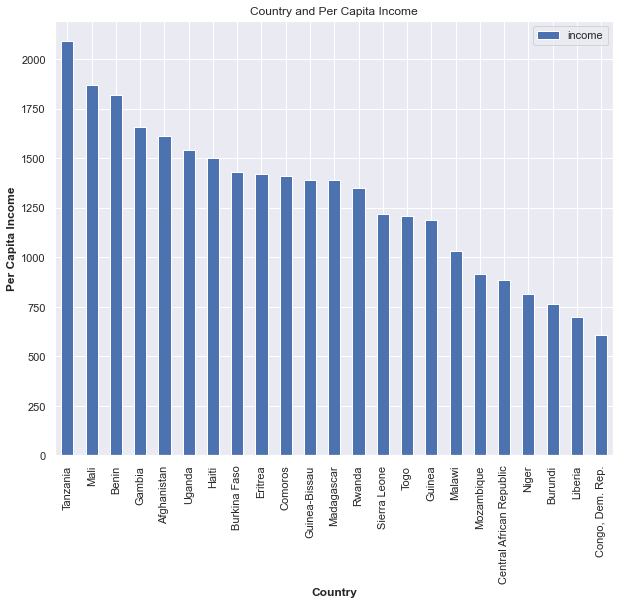

In [78]:
# BarPlot for Per Capita Income of countries which are in need of aid

df_list_in = pd.DataFrame(df_final_list2.groupby(['country'])['income'].mean().sort_values(ascending = False))
df_list_in.plot.bar()
plt.title('Country and Per Capita Income')
plt.xlabel("Country",fontweight = 'bold')
plt.ylabel("Per Capita Income", fontsize = 12, fontweight = 'bold')
plt.show()

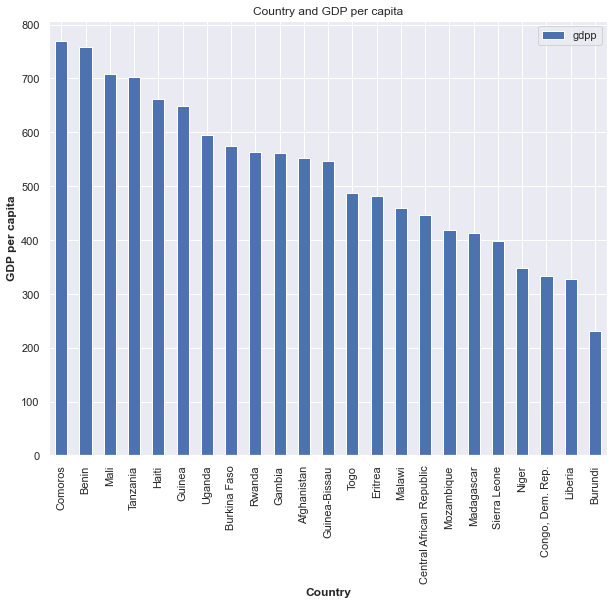

In [79]:
# BarPlot for Per Capita Income of countries which are in need of aid

df_list_gdp = pd.DataFrame(df_final_list2.groupby(['country'])['gdpp'].mean().sort_values(ascending = False))
df_list_gdp.plot.bar()
plt.title('Country and GDP per capita')
plt.xlabel("Country",fontweight = 'bold')
plt.ylabel("GDP per capita", fontsize = 12, fontweight = 'bold')
plt.show()

### Closing Statement

We have used PCA above to reduce the variables involved and then done the clustering of countries based on those Principal components
and then later we identified few factors like `child mortality`, `income` etc which plays a vital role in deciding the development status of the country and builded clusters of countries based on that.
Based on those clusters we have identified the below list of countries which are in dire need of aid.
The list of countries are subject to change as it is based on the few factors like `Number of components chosen`,
`Number of Clusters chosen`, `Clustering method used` etc.which we have used to build the model. 

In [80]:
# Final countries list
df_final_list2.reset_index(drop=True).country

0     Afghanistan             
1     Benin                   
2     Burkina Faso            
3     Burundi                 
4     Central African Republic
5     Comoros                 
6     Congo, Dem. Rep.        
7     Eritrea                 
8     Gambia                  
9     Guinea                  
10    Guinea-Bissau           
11    Haiti                   
12    Liberia                 
13    Madagascar              
14    Malawi                  
15    Mali                    
16    Mozambique              
17    Niger                   
18    Rwanda                  
19    Sierra Leone            
20    Tanzania                
21    Togo                    
22    Uganda                  
Name: country, dtype: object